# COVID-19 and Population project

In this project I am evaluating the Coronavitus data in order to answer some questions like:

**1. Which is the most related variable to COVID-19 Cases?**

**2. Is COVID-19 related to the age?**

**3. Are the countries with some kind of free Healthcare policies more affected than the rest?**

## Section 1. Gather the data
The first step is call the libraries and get the dataset:


In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapefile as shp
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import geopandas as gpd
%matplotlib inline

#I get the df from website worldometers.info

url_popu = 'https://www.worldometers.info/world-population/population-by-country/'
url_covid = 'https://www.worldometers.info/coronavirus/#countries'
#url that I used for downloading the data
r_popu = requests.get(url_popu)
r_covid = requests.get(url_covid)
soup_popu = BeautifulSoup(r_popu.content)
soup_covid = BeautifulSoup(r_covid.content)
countries_popu = soup_popu.find_all('table')[0]
countries_covid = soup_covid.find_all('table')[0]
df_popu = pd.read_html(str(countries_popu))[0]
df_covid = pd.read_html(str(countries_covid))[0]

#Also I get a healthcare from a csv file, a list of countries with free Healtcare policies
df_healthcare = pd.read_csv('countries with free healthcare.csv')

### 1.1. First visualization

You can see below the heads of the created **DataFrames**

In [2]:
df_popu.head()

,#,Country (or dependency),Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,1,China,1439323776,0.39 %,5540090,153,9388211,-348399.0,1.7,38,61 %,18.47 %
1,2,India,1380004385,0.99 %,13586631,464,2973190,-532687.0,2.2,28,35 %,17.70 %
2,3,United States,331002651,0.59 %,1937734,36,9147420,954806.0,1.8,38,83 %,4.25 %
3,4,Indonesia,273523615,1.07 %,2898047,151,1811570,-98955.0,2.3,30,56 %,3.51 %
4,5,Pakistan,220892340,2.00 %,4327022,287,770880,-233379.0,3.6,23,35 %,2.83 %


In [3]:
df_covid.head()

,"Country,Other",TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,ActiveCases,"Serious,Critical",Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/ 1M pop
0,World,3391040,"+87,119",239097.0,"+5,273",1077835.0,2074108,51332.0,435.0,30.7,NaN,NaN
1,USA,1125095,"+30,072",65529.0,"+1,673",160173.0,899393,16478.0,3399.0,198.0,6637773.0,20054.0
2,Spain,242988,"+3,648",24824.0,+281,142450.0,75714,2500.0,5197.0,531.0,1528833.0,32699.0
3,Italy,207428,"+1,965",28236.0,+269,78249.0,100943,1578.0,3431.0,467.0,2053425.0,33962.0
4,UK,177454,"+6,201",27510.0,+739,NaN,149600,1559.0,2614.0,405.0,1023824.0,15082.0


I want to change some columns names:

In [4]:
df_covid.rename(columns={"TotalCases": "Total_Cases",
                   "TotalDeaths": "Total_Deaths", 
                  'TotalRecovered': 'Total_Recovered',
                  'TotalTests': 'Total_Tests'}, inplace=True)

In [5]:
df_healthcare.head()

,name,pop2020
0,Albania,2877.797
1,Algeria,43851.044
2,Andorra,77.265
3,Antigua and Barbuda,97.929
4,Argentina,45195.774


### 1.2. Creating a new dataframe

I will use a new DataFrame based in the Population one. I will call it **df_raw**

In [6]:
#I get the columns that I want to use from df_popu

df_raw = pd.DataFrame()
df_raw['Country'] = df_popu['Country (or dependency)']
df_raw['Population'] = df_popu['Population (2020)']
df_raw['People_per_sqKm'] = df_popu['Density (P/Km²)']
df_raw['Migrants'] = df_popu['Migrants (net)']
df_raw['Avg_Age'] = df_popu['Med. Age']
df_raw['Urban_Pop_perc'] = df_popu['Urban Pop %']

df_raw.head()

,Country,Population,People_per_sqKm,Migrants,Avg_Age,Urban_Pop_perc
0,China,1439323776,153,-348399.0,38,61 %
1,India,1380004385,464,-532687.0,28,35 %
2,United States,331002651,36,954806.0,38,83 %
3,Indonesia,273523615,151,-98955.0,30,56 %
4,Pakistan,220892340,287,-233379.0,23,35 %


### 1.3. Joining Dataframes

I am going to **join** df_raw with the Covid-19 data and Healthcare data.
All have the countries in common, although the spelling is not the same. I have created two **dictionaries** to make a match for all the countries.

In [7]:

covid_dic = {'USA':'United States', 'UK':'United Kingdom', 'S. Korea':'South Korea', 'UAE':'United Arab Emirates',
               'Czechia':'Czech Republic (Czechia)', 'Ivory Coast':"Côte d'Ivoire", 'DRC':'DR Congo',
               'Palestine':'State of Palestine', 'CAR':'Central African Republic', 'Saint Kitts and Nevis':'Saint Kitts & Nevis',
               'St. Vincent Grenadines':'St. Vincent & Grenadines', 'Vatican City':'Holy See', 'St. Barth':'Saint Barthelemy',
               'Sao Tome and Principe':'Sao Tome & Principe', 'Saint Pierre Miquelon':'Saint Pierre & Miquelon'}

df_covid.replace({'Country,Other': covid_dic},  inplace = True)


healthcare_dic = {'Czech Republic':'Czech Republic (Czechia)',
           'Macau':'Macao',
           'Saint Vincent and the Grenadines':'St. Vincent & Grenadines'}

df_healthcare.replace({'name': healthcare_dic},  inplace = True)


In [8]:
df_covid.head()


,"Country,Other",Total_Cases,NewCases,Total_Deaths,NewDeaths,Total_Recovered,ActiveCases,"Serious,Critical",Tot Cases/1M pop,Deaths/1M pop,Total_Tests,Tests/ 1M pop
0,World,3391040,"+87,119",239097.0,"+5,273",1077835.0,2074108,51332.0,435.0,30.7,NaN,NaN
1,United States,1125095,"+30,072",65529.0,"+1,673",160173.0,899393,16478.0,3399.0,198.0,6637773.0,20054.0
2,Spain,242988,"+3,648",24824.0,+281,142450.0,75714,2500.0,5197.0,531.0,1528833.0,32699.0
3,Italy,207428,"+1,965",28236.0,+269,78249.0,100943,1578.0,3431.0,467.0,2053425.0,33962.0
4,United Kingdom,177454,"+6,201",27510.0,+739,NaN,149600,1559.0,2614.0,405.0,1023824.0,15082.0


In [9]:
df_healthcare.head()

,name,pop2020
0,Albania,2877.797
1,Algeria,43851.044
2,Andorra,77.265
3,Antigua and Barbuda,97.929
4,Argentina,45195.774


Now **columns**:  "Country", "Country,Other" and "name" from df_raw, df_covid and df_healtcare has the countries with the same spelling.

Prior to the **join** lets remove some columns that I do not want to evaluate. Also I will create a column in df_healthcare with 1 as the value.

That will make easier the join, you will see the Free_healthcare column with values **"1"** upon countries with Free healthcare policies and **NaN** values on the rest, I will change NaN to 0 later on


In [10]:
#I remove the columns from df_covid that I am not interested in 
df_covid = df_covid.drop(['NewCases','NewDeaths','ActiveCases','Serious,Critical',df_covid.columns[8],'Tests/ 1M pop','Deaths/1M pop'],axis=1)
df_healthcare['Free_healthcare'] = 1 #I create a column in healthcar with 1 as the value
df_healthcare.drop(['pop2020'], axis=1, inplace=True)

In [11]:
df_covid.head()

,"Country,Other",Total_Cases,Total_Deaths,Total_Recovered,Total_Tests
0,World,3391040,239097.0,1077835.0,NaN
1,United States,1125095,65529.0,160173.0,6637773.0
2,Spain,242988,24824.0,142450.0,1528833.0
3,Italy,207428,28236.0,78249.0,2053425.0
4,United Kingdom,177454,27510.0,NaN,1023824.0


In [12]:
df_healthcare.head()

,name,Free_healthcare
0,Albania,1
1,Algeria,1
2,Andorra,1
3,Antigua and Barbuda,1
4,Argentina,1


#### Finally the Join

In [13]:
#I join both tables using as index the country
df_raw = df_raw.join(df_healthcare.set_index('name'), on='Country')
df_raw = df_raw.join(df_covid.set_index('Country,Other'), on='Country')

df_raw.head()

,Country,Population,People_per_sqKm,Migrants,Avg_Age,Urban_Pop_perc,Free_healthcare,Total_Cases,Total_Deaths,Total_Recovered,Total_Tests
0,China,1439323776,153,-348399.0,38,61 %,1.0,82874.0,4633.0,77642.0,NaN
1,India,1380004385,464,-532687.0,28,35 %,NaN,37257.0,1223.0,10007.0,902654.0
2,United States,331002651,36,954806.0,38,83 %,NaN,1125095.0,65529.0,160173.0,6637773.0
3,Indonesia,273523615,151,-98955.0,30,56 %,NaN,10551.0,800.0,1591.0,102305.0
4,Pakistan,220892340,287,-233379.0,23,35 %,1.0,18092.0,417.0,4351.0,182131.0


### 2. Assess

Well before clean and analyze the figures, lets understand which kind of data we have:

In [14]:
df_raw.dtypes

Country             object
Population           int64
People_per_sqKm      int64
Migrants           float64
Avg_Age             object
Urban_Pop_perc      object
Free_healthcare    float64
Total_Cases        float64
Total_Deaths       float64
Total_Recovered    float64
Total_Tests        float64
dtype: object

It seems that most of our variables are numbers! that is good to evaluate the dataframe, however we shall understand the Free Healthcare as a Categorical value:

   **1** means "yes", with Free Healthcare policies
   
   **NaN** means the contrary (we will change it later to "0")
    
In any case we have 2 objects types: Avg_Age and Urban_Pop and Country.
Country will be maintain here, but will be removed later for the evaluation of the model, I do not care about the countries, just about the figures, and we have a single figure for each country.

For the rest of the **objects**, those are **not categorical vales**, should be **numerical**. Lets find out why and change it to numbers.

### 2.1. Checking the objects

In [15]:
df_raw['Avg_Age'].unique()#looking for the value that make the column an object

array(['38', '28', '30', '23', '33', '18', '40', '29', '48', '19', '26',
       '25', '32', '17', '46', '42', '47', '20', '44', '31', '45', '41',
       '21', '22', '35', '15', '34', '16', '43', '24', '27', '37', '36',
       '39', 'N.A.'], dtype=object)

In [16]:
df_raw['Urban_Pop_perc'].unique()#looking for the value that make the column an object

array(['61 %', '35 %', '83 %', '56 %', '88 %', '52 %', '39 %', '74 %',
       '84 %', '92 %', '21 %', '47 %', '43 %', '38 %', '46 %', '76 %',
       '51 %', '82 %', '69 %', '37 %', '67 %', '31 %', '28 %', '80 %',
       '26 %', '93 %', '73 %', '25 %', '60 %', '81 %', '64 %', '50 %',
       '79 %', '78 %', '57 %', 'N.A.', '63 %', '86 %', '17 %', '18 %',
       '44 %', '55 %', '85 %', '58 %', '45 %', '49 %', '24 %', '23 %',
       '48 %', '14 %', '70 %', '98 %', '91 %', '66 %', '72 %', '27 %',
       '13 %', '36 %', '62 %', '53 %', '54 %', '87 %', '68 %', '96 %',
       '71 %', '59 %', '89 %', '33 %', '41 %', '30 %', '100 %', '29 %',
       '65 %', '94 %', '19 %', '95 %', '97 %', '0 %', '15 %', '75 %',
       '10 %'], dtype=object)

It seems that the problem is **N.A.** and **%**.

Firstly, I will replace chr **'%'** and then, I will use pandas **tonumeric** to change the type

In [17]:
df_raw['Urban_Pop_perc'] = [perc.replace(' %','') for perc in df_raw['Urban_Pop_perc']]

In [18]:
df_raw['Avg_Age'] = pd.to_numeric(df_raw['Avg_Age'],errors='coerce')
df_raw['Urban_Pop_perc'] = pd.to_numeric(df_raw['Urban_Pop_perc'],errors='coerce')/100

In [19]:
df_raw.head()

,Country,Population,People_per_sqKm,Migrants,Avg_Age,Urban_Pop_perc,Free_healthcare,Total_Cases,Total_Deaths,Total_Recovered,Total_Tests
0,China,1439323776,153,-348399.0,38.0,0.61,1.0,82874.0,4633.0,77642.0,NaN
1,India,1380004385,464,-532687.0,28.0,0.35,NaN,37257.0,1223.0,10007.0,902654.0
2,United States,331002651,36,954806.0,38.0,0.83,NaN,1125095.0,65529.0,160173.0,6637773.0
3,Indonesia,273523615,151,-98955.0,30.0,0.56,NaN,10551.0,800.0,1591.0,102305.0
4,Pakistan,220892340,287,-233379.0,23.0,0.35,1.0,18092.0,417.0,4351.0,182131.0


In [20]:
df_raw.dtypes

Country             object
Population           int64
People_per_sqKm      int64
Migrants           float64
Avg_Age            float64
Urban_Pop_perc     float64
Free_healthcare    float64
Total_Cases        float64
Total_Deaths       float64
Total_Recovered    float64
Total_Tests        float64
dtype: object

Finally I will create a column with the index, named **Country_Id**, to keep the traceability of the data, since later on I will remove Country column. Also I will keep a dictionary to save its relationship


In [21]:
#dic_country_idx = dict(zip(df_raw.index.tolist(),df_raw['Country'].tolist()))


## 3. Clean and analyze the model

Now  I create a function that cleans the DF, create the model and gives back:

**1.** The r squared value to know if the model is ok to predict cases

**2.** The effect grade

**3.** The coefficients of the model

In my case the X will be always the population and Healthcare columns. Regarding the 'y', I will check all the columns from COVID: total cases, total deaths, total recovered and total tests.


#### Function

To understand the cleaning, let's see the proportion of **NaN** values in each column:

In [22]:
df_raw.isnull().mean()

Country            0.000000
Population         0.000000
People_per_sqKm    0.000000
Migrants           0.144681
Avg_Age            0.144681
Urban_Pop_perc     0.055319
Free_healthcare    0.523404
Total_Cases        0.097872
Total_Deaths       0.263830
Total_Recovered    0.131915
Total_Tests        0.238298
dtype: float64

In [23]:
df_raw['Free_healthcare'].fillna(0, inplace=True)
#As I mentioned in 1.3, NaN values of this column are changed to 0 (representing NO) 

In [24]:
def get_model_inf(df, resp):
    '''
    INPUT
    df - pandas dataframe 
    resp - column name for the y
    
    OUTPUT
    rsquared value
    effect of the rsquared 
    dataframe of the model coefficients
    '''
    #first we remove the 'Country' column, which does not add value to our model
    df = df.drop(['Country'],axis=1)
    
    #then I drop the columns that I do not want to use depending on which is the response vector
    if resp == 'Total_Cases':
        df = df.drop(['Total_Deaths','Total_Recovered', 'Total_Tests'],axis=1)
    elif resp == 'Total_Deaths':
        df = df.drop(['Total_Cases','Total_Recovered','Total_Tests'],axis=1)
    elif resp == 'Total_Recovered':
        df = df.drop(['Total_Cases','Total_Deaths','Total_Tests'],axis=1)
    elif resp == 'Total_Tests':
        df = df.drop(['Total_Cases','Total_Deaths','Total_Recovered'],axis=1)
        df['Total_Tests'].fillna(0, inplace=True)#I assume that, if there are no figures for test, country is not doing test
    else:
        print('error, no right input')
    
    #I remove any NaN
    df = df.dropna(subset=[resp], axis=0)
    #Below I remove the NaN with the average of each column
    df['Avg_Age'].fillna((df['Avg_Age'].mean()), inplace=True)
    df['Urban_Pop_perc'].fillna((df['Urban_Pop_perc'].mean()), inplace=True)
    df['Migrants'].fillna((df['Migrants'].mean()), inplace=True)
    #I create the X matrix and the y response vector
    y = df[resp]
    df = df.drop([resp], axis=1)
    X = df
    #Rsquared and y_test
    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X, y) #Fit
    y_preds = lm_model.predict(X)
    rsquared_score = r2_score(y, y_preds)
    
    if rsquared_score<0.3:
        effect = 'very weak'
    elif rsquared_score<0.5:
        effect = 'weak'
    elif rsquared_score<0.7:
        effect = 'moderate'
    else:
        effect = 'strong'
    #here I get the coefficients
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return rsquared_score, effect, coefs_df

#### Analyzing the model

In [25]:
#4 possible evaluations, TotalCases, TotalDeaths and TotalRecovered
resp_cases = ['Total_Cases','Total_Deaths','Total_Recovered','Total_Tests']
for case in resp_cases:
    rsquared_score, effect, coefs_df = get_model_inf(df_raw,case)
    print("With {} as vector response: The rsquared is {}.".format(case.replace('_',' '),rsquared_score))
    print('Such rsquared value means that the effect is {}.\n'.format(effect))
    print('Its coefficients dataframe is:\n\t')
    print(coefs_df)

With Total Cases as vector response: The rsquared is 0.5357210795300149.
Such rsquared value means that the effect is moderate.

Its coefficients dataframe is:
	
           est_int         coefs     abs_coefs
5  Free_healthcare -10855.682532  10855.682532
4   Urban_Pop_perc  -3218.163274   3218.163274
3          Avg_Age    680.653386    680.653386
2         Migrants      0.497514      0.497514
1  People_per_sqKm     -0.492754      0.492754
0       Population      0.000244      0.000244
With Total Deaths as vector response: The rsquared is 0.42775485264832414.
Such rsquared value means that the effect is weak.

Its coefficients dataframe is:
	
           est_int       coefs   abs_coefs
5  Free_healthcare -921.727964  921.727964
4   Urban_Pop_perc  -90.942385   90.942385
3          Avg_Age   87.512933   87.512933
1  People_per_sqKm   -0.060466    0.060466
2         Migrants    0.030585    0.030585
0       Population    0.000014    0.000014
With Total Recovered as vector response: The rsq

#### Moderate

is the relation between COVID-19 cases and the matrix evaluated.
Let see which is  the actual relationship between all of them in some **insights**.

But, firstly, since **TOTAL CASES** is the best represented column, I am going to clean df_raw and clean the NaN

In [26]:
df_plot = df_raw.copy()
df_plot = df_plot.dropna(subset=['Total_Cases'], axis=0)
#Below I remove the NaN with a "0"
df_plot['Total_Deaths'].fillna(0, inplace=True)
df_plot['Total_Recovered'].fillna(0, inplace=True)
df_plot['Total_Tests'].fillna(0, inplace=True)
#Below I remove the NaN with the average of each column
df_plot['Avg_Age'].fillna((df_plot['Avg_Age'].mean()), inplace=True)
df_plot['Urban_Pop_perc'].fillna((df_plot['Urban_Pop_perc'].mean()), inplace=True)
df_plot['Migrants'].fillna((df_plot['Migrants'].mean()), inplace=True)
df_plot.isnull().mean()

Country            0.0
Population         0.0
People_per_sqKm    0.0
Migrants           0.0
Avg_Age            0.0
Urban_Pop_perc     0.0
Free_healthcare    0.0
Total_Cases        0.0
Total_Deaths       0.0
Total_Recovered    0.0
Total_Tests        0.0
dtype: float64

In [27]:
df_plot.head()

,Country,Population,People_per_sqKm,Migrants,Avg_Age,Urban_Pop_perc,Free_healthcare,Total_Cases,Total_Deaths,Total_Recovered,Total_Tests
0,China,1439323776,153,-348399.0,38.0,0.61,1.0,82874.0,4633.0,77642.0,0.0
1,India,1380004385,464,-532687.0,28.0,0.35,0.0,37257.0,1223.0,10007.0,902654.0
2,United States,331002651,36,954806.0,38.0,0.83,0.0,1125095.0,65529.0,160173.0,6637773.0
3,Indonesia,273523615,151,-98955.0,30.0,0.56,0.0,10551.0,800.0,1591.0,102305.0
4,Pakistan,220892340,287,-233379.0,23.0,0.35,1.0,18092.0,417.0,4351.0,182131.0


## 4.Visualize 

  I am going to prove to see what says an histogram for the new df_plot

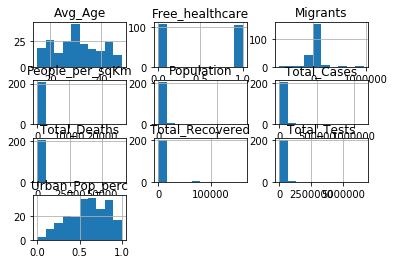

In [28]:
df_plot.hist();

Above histogrand does not tell me much to me, let see a heatmap:

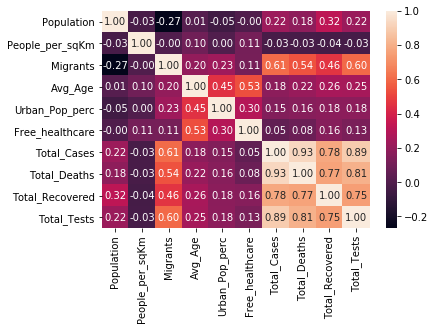

In [29]:
sns.heatmap(df_plot.corr(), annot= True, fmt='.2f');

It seems quite better, I can see a high correlation with Migrants, let see it with a higher detail.

In [30]:
df_corr = df_plot.corr()
df_corr = df_corr[['People_per_sqKm','Migrants','Avg_Age','Urban_Pop_perc','Free_healthcare']]
df_corr = df_corr.drop(['Population','People_per_sqKm','Migrants','Avg_Age','Urban_Pop_perc','Free_healthcare'],axis=0)
df_corr

,People_per_sqKm,Migrants,Avg_Age,Urban_Pop_perc,Free_healthcare
Total_Cases,-0.027159,0.607728,0.180033,0.149290,0.049226
Total_Deaths,-0.029462,0.542121,0.216089,0.163854,0.079763
Total_Recovered,-0.037764,0.462563,0.258531,0.175182,0.159490
Total_Tests,-0.034867,0.600139,0.253075,0.179211,0.127787


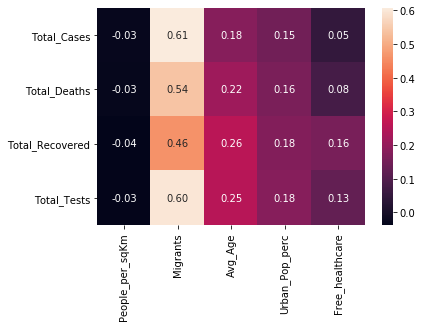

In [31]:
sns.heatmap(df_corr, annot= True, fmt='.2f');


In [32]:
plt.savefig('heatmap_01.png')#I like the pic and I save it

<Figure size 432x288 with 0 Axes>

### First question answered

**Migrants** is the column with a higher correlation with the COVID-19 cases, I was expecting People per square Kilometer, but it is not related at all! actually it have negative relationship.

I want to plot the scatter of the columns with a higher relationship, TOTAL CASES and MIGRANTS. to double check its relationship.


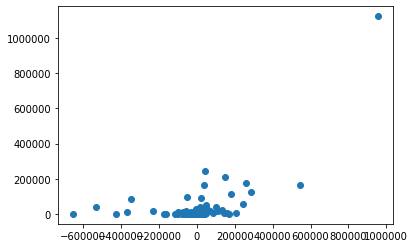

In [33]:

plt.scatter(df_plot['Migrants'],df_plot['Total_Cases'])

plt.show()

Let see the **linear regression** in the plot. I am going to create functions to make life easier

In [35]:
from scipy import stats


In [36]:
def plot_lin(x,y):
    slope, intercept, r, p, std_err = stats.linregress(x, y)
    mymodel = list(map(lambda x: slope * x + intercept, x))
    plt.scatter(x, y)
    plt.plot(x, mymodel)
    return plt, r

In [42]:
def plot_poly(x,y,mini,maxi,grade):
    mymodel = np.poly1d(np.polyfit(x, y, grade))
    myline = np.linspace(mini, maxi, 100)
    plt.scatter(x, y)
    plt.plot(myline, mymodel(myline))
    r = r2_score(y, mymodel(x))
    return plt, r

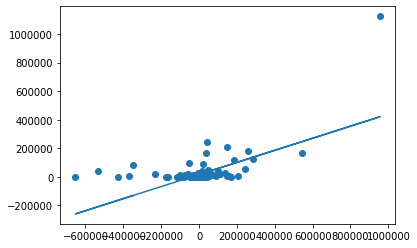

In [43]:
plt, r = plot_lin(df_plot['Migrants'],df_plot['Total_Cases'])

plt.show() 

In [44]:
r#check the r2

0.6077281506999747

It seems that a polynomial regression will match much better:

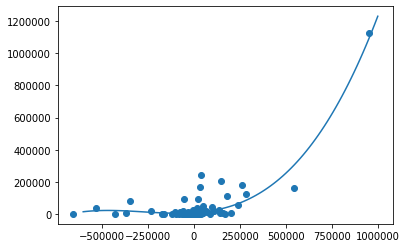

In [45]:
plt, r2_score = plot_poly(df_plot['Migrants'],df_plot['Total_Cases'],-600000,1000000,3)
plt.show()


In [46]:
r2_score#check the r2

0.8755957852941212

#### GREAT

I have got a curve that represents the relation between them in a right way.

Now, I will plotter the Average age


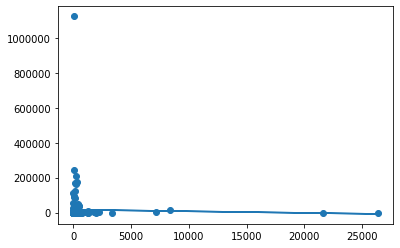

In [47]:
plt, r = plot_lin(df_plot['People_per_sqKm'],df_plot['Total_Cases'])

plt.show() 

In [ ]:
sns.heatmap(df_raw.corr(), annot= True, fmt='.2f');
equis = df_raw['Migrants']
ygriega = df_raw['Total_Recovered']
#mymodel = np.poly1d(np.polyfit(equis, ygriega, 3))

#myline = np.linspace(0, 1, 100)
plt.scatter(equis, ygriega)
#plt.plot(myline, mymodel(myline))
plt.show()

In [ ]:

dic_fh = {1: 'Yes', 0:'No'}


In [ ]:
df_c = pd.DataFrame()

In [ ]:
df_c['Free Healthcare'] = df_raw['Free healthcare']
df_c.replace({'Free Healthcare':dic_fh}, inplace = True)
df_c['Population (2020)'] = df_raw['Population (2020)']
group_dfc2 = df_c.groupby('Free Healthcare').agg({'count','sum'})
df_c['TotalCases'] = df_raw['TotalCases']
df_c['TotalDeaths'] = df_raw['TotalDeaths']
df_c['TotalRecovered'] = df_raw['TotalRecovered']
df_c['TotalTests'] = df_raw['TotalTests']
group_dfc = df_c.groupby('Free Healthcare').sum()
group_dfc['Tests per 1M P']= (group_dfc['TotalTests']*1e6)/group_dfc['Population (2020)']
group_dfc['Cases per 1M P']= (group_dfc['TotalCases']*1e6)/group_dfc['Population (2020)']
group_dfc['Deaths per 100 Cases'] = (group_dfc['TotalDeaths']*100)/group_dfc['TotalCases']
group_dfc['Recovered per 100 Cases'] = (group_dfc['TotalRecovered']*100)/group_dfc['TotalCases']
group_dfc['Deaths per 1M P'] = (group_dfc['TotalDeaths']*1e6)/group_dfc['Population (2020)']
group_dfc['Recovered per 1M P'] = (group_dfc['TotalRecovered']*1e6)/group_dfc['Population (2020)']
rate_expected = group_dfc.loc['No','Cases per 1M P']/group_dfc.loc['Yes','Cases per 1M P']
death_rate = group_dfc.loc['No','Deaths per 100 Cases']/group_dfc.loc['Yes','Deaths per 100 Cases']
expected_deaths = group_dfc.loc['Yes','Deaths per 100 Cases']*rate_expected
expected_recovered =  group_dfc.loc['Yes','Recovered per 100 Cases']*death_rate
"We might expect {} deaths per each 100 cases in countries with no free Healthcare, however we see 5.55 per 100 Cases. Also, we might expect {} recovered cases per each 100 using the previous rate, but again we find  15.3 recovered cases only per each 100.".format(expected_deaths,expected_recovered)

In [ ]:


df_new = pd.DataFrame()
df_new['Tests per 1M P']=group_dfc['Tests per 1M P'].apply(lambda x: "{0:.2f}".format(x))
df_new['Cases per 1M P']=group_dfc['Cases per 1M P'].apply(lambda x: "{0:.2f}".format(x))
df_new['Deaths per 1M P']=group_dfc['Deaths per 1M P'].apply(lambda x: "{0:.2f}".format(x))
df_new['Case Recovery rate']=group_dfc['Recovered per 100 Cases'].apply(lambda x: "{0:.2f}%".format(x))
df_new['Case fatality rate']=group_dfc['Deaths per 100 Cases'].apply(lambda x: "{0:.2f}%".format(x))
df_new



In [ ]:

index = ['Non-Free Healthcare','Free Healthcare']
df_p = pd.DataFrame(index=index)
df_p['Countries'] = [group_dfc2[('Population (2020)', 'count')][0],group_dfc2[('Population (2020)', 'count')][1]]
df_p['Population'] = [group_dfc2[('Population (2020)', 'sum')][0],group_dfc2[('Population (2020)', 'sum')][1]]

fig = plt.figure(figsize=(6, 4)) # Create matplotlib figure


ax = fig.add_subplot() # Create matplotlib axes
ax = df_p['Countries'].plot(kind='bar', color='#dca07b', use_index=True)
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
ax2.plot(ax.get_xticks(),
         df_p['Population'].values,
         linestyle=' ',
         marker='o', color='#c5ed5a')
ax.set_ylabel('Number of countries')
ax2.set_ylabel('Billions of People')

ax.set_ylim((0, 160))



#ax2.xaxis.set_major_formatter(billi)



In [ ]:

df_p['Population'] = df_p['Population'].apply(lambda x: "{0:.2f}B".format(x * 1e-9))


In [ ]:
df_p


In [ ]:
df_raw['Med. Age'].fillna(round((df_raw['Med. Age'].mean()),0), inplace=True)




In [ ]:
df_raw['rank age'] = df_raw['Med. Age'].apply(sfu.age_rank)
df_raw

In [ ]:
df_cha = pd.DataFrame()

df_cha['Age Rank']=df_raw['rank age'] 
df_cha['TotalCases']=df_raw['TotalCases']
df_cha['Population (2020)']=df_raw['Population (2020)']



df_g= df_cha.groupby(['Age Rank']).agg(['sum','count'])
df_g



In [ ]:
df_g['Number of Countries'] = df_g[('TotalCases','count')]
df_g['Cases per 1M P'] = (df_g[('TotalCases','sum')])*1e6/df_g[('Population (2020)','sum')]
df_g = df_g.drop([('TotalCases','sum'),('TotalCases','count'),('Population (2020)','sum'),('Population (2020)','count')],axis=1)

In [ ]:

df_g=df_g.iloc[[4,2,1,0,3],[0,1]]
df_g

In [ ]:
ax = df_g['Cases per 1M P'].plot.bar(rot=0,color='#3086c1')
ax2 = ax.twinx()

ax2.plot(ax.get_xticks(),
         df_g['Number of Countries'].values,
         linestyle=' ',
         marker='o', color='#c5ed5a')

ax.set_ylabel('Cases per 1M people')
ax2.set_ylabel('Number of countries')



In [ ]:
# set the filepath and load
fp = 'World_Countries.shp'
#reading the file stored in variable fp
map_df = gpd.read_file(fp)
# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
map_df.head()

In [ ]:
map_df.plot()

In [ ]:
df = gpd.read_file(fp)

In [ ]:
df.head()

In [ ]:
data_for_map = df.rename(index=str, columns={'COUNTRY': 'COUNTRY', 'geometry': 'geometry'})

In [ ]:
df_raw['Country'] = df_raw['Country (or dependency)']
df_raw.replace({'Country': dic_reverse},  inplace = True)


In [ ]:
arr_dict = {'Afghanistan':'Afghanistan',
'Albania':'Albania',
'Algeria':'Algeria',
'American Samoa':'American Samoa (US)',
'Andorra':'Andorra',
'Angola':'Angola',
'Anguilla':'Anguilla (UK)',
'Antigua and Barbuda':'Antigua and Barbuda',
'Argentina':'Argentina',
'Armenia':'Armenia',
'Aruba':'Aruba (Netherlands)',
'Australia':'Australia',
'Austria':'Austria',
'Azerbaijan':'Azerbaijan',
'Bahamas':'Bahamas',
'Bahrain':'Bahrain',
'Bangladesh':'Bangladesh',
'Barbados':'Barbados',
'Belarus':'Belarus',
'Belgium':'Belgium',
'Belize':'Belize',
'Benin':'Benin',
'Bermuda':'Bermuda (UK)',
'Bhutan':'Bhutan',
'Bolivia':'Bolivia',
'Bosnia and Herzegovina':'Bosnia and Herzegovina',
'Botswana':'Botswana',
'Brazil':'Brazil',
'British Virgin Islands':'British Virgin Islands(UK)',
'Brunei':'Brunei',
'Bulgaria':'Bulgaria',
'Burkina Faso':'Burkina Faso',
'Burundi':'Burundi',
'Cabo Verde':'Cape Verde',
'Cambodia':'Cambodia',
'Cameroon':'Cameroon',
'Canada':'Canada',
'Caribbean Netherlands':'Netherlands',
'Cayman Islands':'Cayman Islands (UK)',
'Central African Republic':'Central African Republic',
'Chad':'Chad',
'Channel Islands':'Channel Islands',
'Chile':'Chile',
'China':'China',
'Colombia':'Colombia',
'Comoros':'Comoros',
'Congo':'Congo',
'Cook Islands':'Cook Islands (New Zealand)',
'Costa Rica':'Costa Rica',
"Côte d'Ivoire":'Ivory Coast',
'Croatia':'Croatia',
'Cuba':'Cuba',
'Curaçao':'Curacao (Netherlands)',
'Cyprus':'Cyprus',
'Czech Republic (Czechia)':'Czech Republic',
'Denmark':'Denmark',
'Djibouti':'Djibouti',
'Dominica':'Dominica',
'Dominican Republic':'Dominican Republic',
'DR Congo':'Democratic Republic of the Congo',
'Ecuador':'Ecuador',
'Egypt':'Egypt',
'El Salvador':'El Salvador',
'Equatorial Guinea':'Equatorial Guinea',
'Eritrea':'Eritrea',
'Estonia':'Estonia',
'Eswatini':'Swaziland',
'Ethiopia':'Ethiopia',
'Faeroe Islands':'Faroe Islands (Denmark)',
'Falkland Islands':'Falkland Islands (UK)',
'Fiji':'Fiji',
'Finland':'Finland',
'France':'France',
'French Guiana':'French Guiana (France)',
'French Polynesia':'French Polynesia (France)',
'Gabon':'Gabon',
'Gambia':'Gambia',
'Georgia':'Georgia',
'Germany':'Germany',
'Ghana':'Ghana',
'Gibraltar':'Gibraltar (UK)',
'Greece':'Greece',
'Greenland':'Greenland (Denmark)',
'Grenada':'Grenada',
'Guadeloupe':'Guadeloupe (France)',
'Guam':'Guam (US)',
'Guatemala':'Guatemala',
'Guinea':'Guinea',
'Guinea-Bissau':'Guinea-Bissau',
'Guyana':'Guyana',
'Haiti':'Haiti',
'Holy See':'Holy See',
'Honduras':'Honduras',
'Hong Kong':'Hong Kong',
'Hungary':'Hungary',
'Iceland':'Iceland',
'India':'India',
'Indonesia':'Indonesia',
'Iran':'Iran',
'Iraq':'Iraq',
'Ireland':'Ireland',
'Isle of Man':'Isle of Man (UK)',
'Israel':'Israel',
'Italy':'Italy',
'Jamaica':'Jamaica',
'Japan':'Japan',
'Jordan':'Jordan',
'Kazakhstan':'Kazakhstan',
'Kenya':'Kenya',
'Kiribati':'Kiribati',
'Kuwait':'Kuwait',
'Kyrgyzstan':'Kyrgyzstan',
'Laos':'Laos',
'Latvia':'Latvia',
'Lebanon':'Lebanon',
'Lesotho':'Lesotho',
'Liberia':'Liberia',
'Libya':'Libya',
'Liechtenstein':'Liechtenstein',
'Lithuania':'Lithuania',
'Luxembourg':'Luxembourg',
'Macao':'Macao',
'Madagascar':'Madagascar',
'Malawi':'Malawi',
'Malaysia':'Malaysia',
'Maldives':'Maldives',
'Mali':'Mali',
'Malta':'Malta',
'Marshall Islands':'Marshall Islands',
'Martinique':'Martinique (France)',
'Mauritania':'Mauritania',
'Mauritius':'Mauritius',
'Mayotte':'Mayotte (France)',
'Mexico':'Mexico',
'Micronesia':'Federated States of Micronesia',
'Moldova':'Moldova',
'Monaco':'Monaco',
'Mongolia':'Mongolia',
'Montenegro':'Montenegro',
'Montserrat':'Montserrat',
'Morocco':'Morocco',
'Mozambique':'Mozambique',
'Myanmar':'Myanmar',
'Namibia':'Namibia',
'Nauru':'Nauru',
'Nepal':'Nepal',
'Netherlands':'Netherlands',
'New Caledonia':'New Caledonia (France)',
'New Zealand':'New Zealand',
'Nicaragua':'Nicaragua',
'Niger':'Niger',
'Nigeria':'Nigeria',
'Niue':'Niue (New Zealand)',
'North Korea':'North Korea',
'North Macedonia':'Macedonia',
'Northern Mariana Islands':'Northern Mariana Islands (US)',
'Norway':'Norway',
'Oman':'Oman',
'Pakistan':'Pakistan',
'Palau':'Palau (US)',
'Panama':'Panama',
'Papua New Guinea':'Papua New Guinea',
'Paraguay':'Paraguay',
'Peru':'Peru',
'Philippines':'Philippines',
'Poland':'Poland',
'Portugal':'Portugal',
'Puerto Rico':'Puerto Rico (US)',
'Qatar':'Qatar',
'Réunion':'Reunion (France)',
'Romania':'Romania',
'Russia':'Russia',
'Rwanda':'Rwanda',
'Saint Barthelemy':'Saint Barthelemy',
'Saint Helena':'St. Helena (UK)',
'Saint Kitts & Nevis':'St. Kitts and Nevis',
'Saint Lucia':'St. Lucia',
'Saint Martin':'Saint Martin',
'Saint Pierre & Miquelon':'St. Pierre and Miquelon (France)',
'Samoa':'Western Samoa',
'San Marino':'San Marino',
'Sao Tome & Principe':'Sao Tome and Principe',
'Saudi Arabia':'Saudi Arabia',
'Senegal':'Senegal',
'Serbia':'Serbia',
'Seychelles':'Seychelles',
'Sierra Leone':'Sierra Leone',
'Singapore':'Singapore',
'Sint Maarten':'Sint Maarten',
'Slovakia':'Slovakia',
'Slovenia':'Slovenia',
'Solomon Islands':'Solomon Islands',
'Somalia':'Somalia',
'South Africa':'South Africa',
'South Korea':'South Korea',
'South Sudan':'South Sudan',
'Spain':'Spain',
'Sri Lanka':'Sri Lanka',
'St. Vincent & Grenadines':'St. Vincent and the Grenadines',
'State of Palestine':'Palestine',
'Sudan':'Sudan',
'Suriname':'Suriname',
'Sweden':'Sweden',
'Switzerland':'Switzerland',
'Syria':'Syria',
'Taiwan':'Taiwan',
'Tajikistan':'Tajikistan',
'Tanzania':'Tanzania',
'Thailand':'Thailand',
'Timor-Leste':'East Timor',
'Togo':'Togo',
'Tokelau':'Tokelau (New Zealand)',
'Tonga':'Tonga',
'Trinidad and Tobago':'Trinidad and Tobago',
'Tunisia':'Tunisia',
'Turkey':'Turkey',
'Turkmenistan':'Turkmenistan',
'Turks and Caicos':'Turks and Caicos Islands (UK)',
'Tuvalu':'Tuvalu',
'U.S. Virgin Islands':'American Virgin Islands (US)',
'Uganda':'Uganda',
'Ukraine':'Ukraine',
'United Arab Emirates':'United Arab Emirates',
'United Kingdom':'United Kingdom',
'United States':'United States',
'Uruguay':'Uruguay',
'Uzbekistan':'Uzbekistan',
'Vanuatu':'Vanuatu',
'Venezuela':'Venezuela',
'Vietnam':'Vietnam',
'Wallis & Futuna':'Wallis and Futuna (France)',
'Western Sahara':'Western Sahara',
'Yemen':'Yemen',
'Zambia':'Zambia',
'Zimbabwe':'Zimbabwe'}

In [ ]:
df_raw.replace({'Country': arr_dict},  inplace = True)

In [ ]:
df_raw.head()

In [ ]:
dfh = pd.DataFrame()
dfh['Country'] = df_raw['Country']
dfh['Free healthcare'] = df_raw['Free healthcare']
dfh['TotalCases'] = df_raw['TotalCases']
dfh['Population (2020)'] = df_raw['Population (2020)']
dfh['TotalDeaths'] = df_raw['TotalDeaths']
dfh['TotalDeaths'].fillna(0, inplace=True)
dfh['Cases per 1M P']=(dfh['TotalCases']*1e6)/dfh['Population (2020)']
dfh['Deaths per 100 cases'] = (dfh['TotalDeaths']*100)/dfh['TotalCases']
dfh['Deaths per 1M P'] =(dfh['TotalDeaths']*1e6)/dfh['Population (2020)']
dfh['Deaths per 1M P'].fillna(0, inplace=True)
dfh['TotalCases'].fillna(0, inplace=True)
dfh['Deaths per 100 cases'].fillna(0, inplace=True)
dfh['Cases per 1M P'].fillna(0, inplace=True)
dfh.isnull().mean()

In [ ]:
merged = map_df.set_index('COUNTRY').join(dfh.set_index('Country'))

In [ ]:
merged.head()

In [ ]:
variable = 'Deaths per 1M P'# set the range for the choropleth
vmin, vmax = 120, 220# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))
merged.plot(column=variable, cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')

In [ ]:
ax.axis('off')# add a title
ax.set_title('Deaths per 1M P', fontdict={'fontsize': '25', 'fontweight' : '3'})# create an annotation for the data source
ax.annotate('Source: worldometers.info',xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

In [ ]:
sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))# empty array for the data range
sm._A = []# add the colorbar to the figure
#cbar = fig.colorbar(sm)
#saving our map as .png file.
fig.savefig('map_export_{}.png'.format('Deaths per 1M P'), dpi=300)

In [ ]:
variable = 'Cases per 1M P'# set the range for the choropleth
vmin, vmax = 120, 220# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))
merged.plot(column=variable, cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')

In [ ]:
ax.axis('off')# add a title
ax.set_title(variable, fontdict={'fontsize': '25', 'fontweight' : '3'})# create an annotation for the data source
ax.annotate('Source: worldometers.info',xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

In [ ]:
sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))# empty array for the data range
sm._A = []# add the colorbar to the figure
#cbar = fig.colorbar(sm)
#saving our map as .png file.
fig.savefig('map_export_{}.png'.format(variable), dpi=300)

In [ ]:
variable = 'Free healthcare'# set the range for the choropleth
vmin, vmax = 120, 220# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))
merged.plot(column=variable, cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='0.8')


In [ ]:
ax.axis('off')# add a title
ax.set_title('Countries with ' + variable, fontdict={'fontsize': '15', 'fontweight' : '3'})# create an annotation for the data source
ax.annotate('Source: https://worldpopulationreview.com/',xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

In [ ]:
sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))# empty array for the data range
sm._A = []# add the colorbar to the figure
#cbar = fig.colorbar(sm)
#saving our map as .png file.
fig.savefig('map_export_{}.png'.format(variable), dpi=300)